In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform

%matplotlib inline

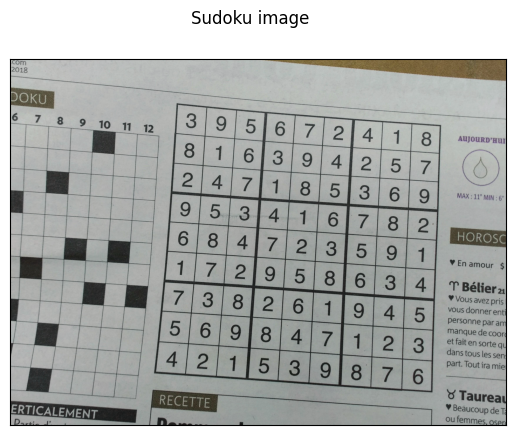

In [ ]:
sudoku_image = cv2.imread("sudoku.jpeg")
gray = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots()
ax.imshow(sudoku_image)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle("Sudoku image")
plt.show()


# Blur

To blur the image we are going to perform a convolution between some averaging kernel and the image. We could use the box filter which will take the average of $n x n$ pixels and assign that value to the center pixel. 

For example, 

$A_3 = \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end{bmatrix}$

Box kernel $ = \frac{A}{||A||} = \begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} 
\end{bmatrix}$


It turns out that the Gaussian Kernel is a much better blur filter as it gives more weight to the nearby neighbors. 

The 2-D gaussian is represented by 
$G(u, v) = \frac{1}{2 \pi \sigma^2}e^{-\frac{u^2+v^2}{2\sigma^2}}$. 

Since we don't want to make the image ligher, we need to normalize the gaussian kernel. The kernel is a discrete representation of the continuous function, therefore we can normalize in the same way as above ($\frac{A}{||A||}$).  

Below, I have plotted the 2-D gaussian function. 

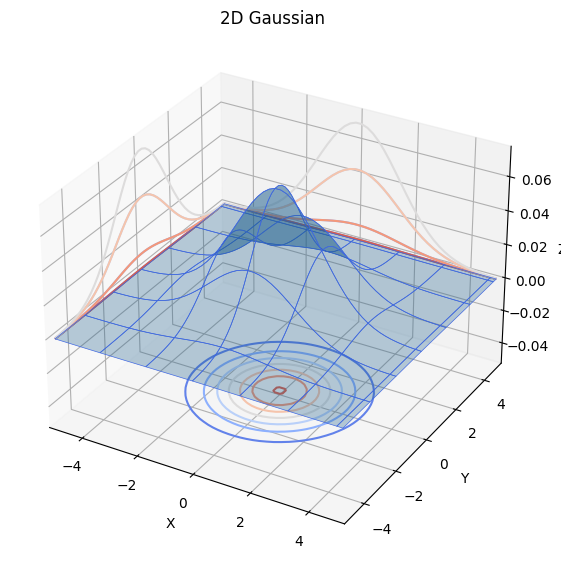

In [ ]:
sigma = 1.5
x = np.linspace(-5,5)
y = np.linspace(-5,5)

x, y = np.meshgrid(x,y)
g = (1/(2 * np.pi * sigma**2)) * np.exp(-(x**2+y**2)/(2*sigma**2))

figure = plt.figure(figsize=(15,15))
ax = figure.add_subplot(2,1,1, projection='3d')

ax.plot_surface(x, y, g, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.set(xlim=(-5,5), ylim=(-5, 5), zlim=(-0.05, 0.075),
       xlabel='X', ylabel='Y', zlabel='Z')
ax.contour(x, y, g, zdir='y', offset=5, cmap='coolwarm')
ax.contour(x, y, g, zdir='x', offset=-5, cmap='coolwarm')
ax.contour(x, y, g, zdir='z', offset=-0.05, cmap='coolwarm')



plt.title("2D Gaussian")
plt.show()

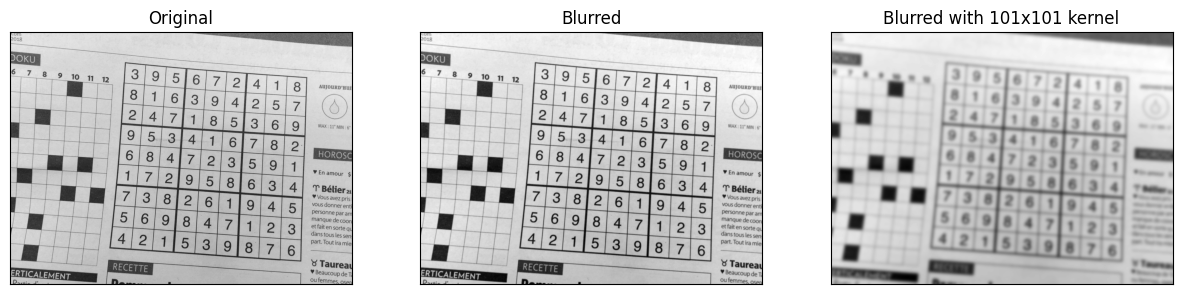

In [ ]:
blur = cv2.GaussianBlur(gray,(15, 15),0)

blur_100 = cv2.GaussianBlur(gray,(101, 101),0)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(x, y)

ax1.imshow(gray, cmap='gray')
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(blur, cmap='gray')
ax2.set_title("Blurred")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(blur_100, cmap='gray')
ax3.set_title("Blurred with 101x101 kernel")
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

# Thresholding

Thresholding is going to replace any pixel below a given threshold value with a black pixel and replace any pixel above the threshold with a white value. 

Adaptive thresholding works similiarly to global thresholding but changes the threshold value in a local region. This will work better when there is variable lighting in the image.

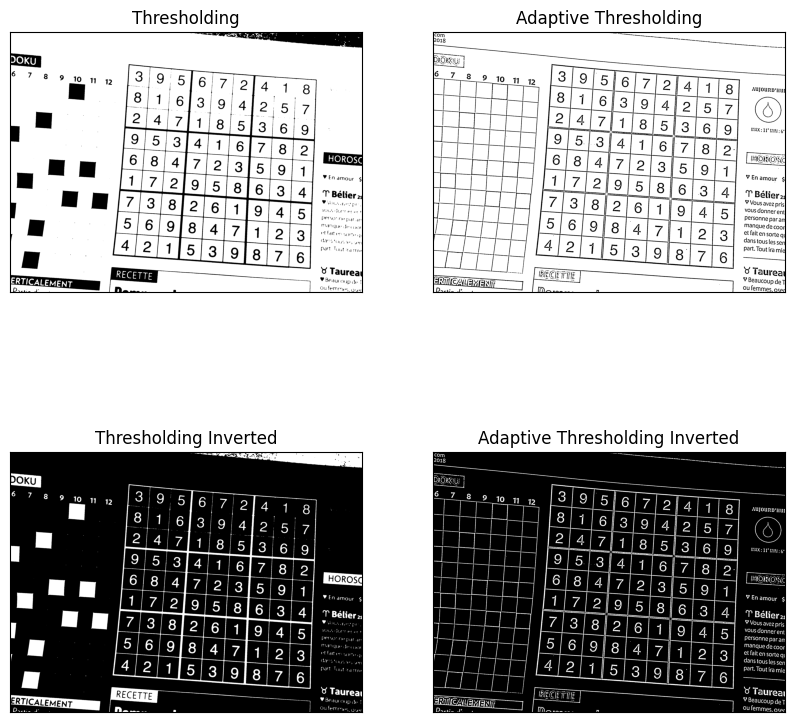

In [ ]:
_, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
threshold_inverted = cv2.bitwise_not(threshold)


adaptive_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 10)
adaptive_threshold_inverted = cv2.bitwise_not(adaptive_threshold)

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0][0].imshow(threshold, cmap='gray')
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])
axs[0][0].set_title("Thresholding")

axs[0][1].imshow(adaptive_threshold, cmap='gray')
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])
axs[0][1].set_title("Adaptive Thresholding")

axs[1][0].imshow(threshold_inverted, cmap='gray')
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][0].set_title("Thresholding Inverted")

axs[1][1].imshow(adaptive_threshold_inverted, cmap='gray')
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
axs[1][1].set_title("Adaptive Thresholding Inverted")

plt.show()

From the above images, we can see the top right corner of the image after thresholding is faded. This is because this light might not be the same throughout the image so we cannot pick a value for the threshold that will perform equally as well throughout. 

From the adaptive thresholding image, we can see it does a pretty good job of finding the image boundary.

# Find sudoku grid

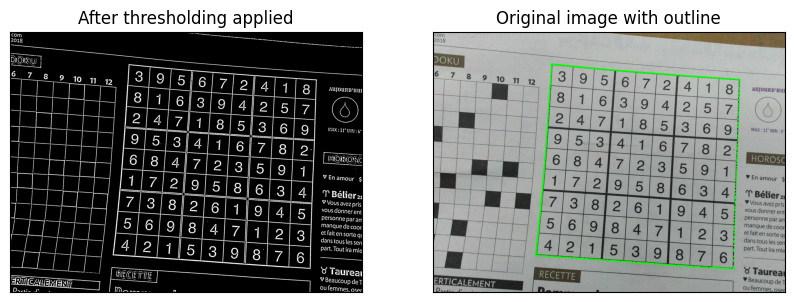

In [ ]:
outlined_image = sudoku_image.copy()
threshold_copy = adaptive_threshold_inverted.copy()

countours = cv2.findContours(threshold_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
countours = imutils.grab_contours(countours)

largest_countour = max(countours, key=cv2.contourArea)

cv2.drawContours(outlined_image, largest_countour, -1, (0, 255, 0), 15)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.imshow(threshold_copy, cmap='gray')
ax1.set_title("After thresholding applied")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(outlined_image)
ax2.set_title("Original image with outline")
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

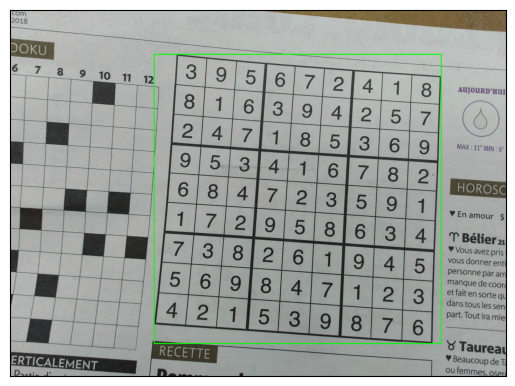

In [ ]:
x, y, w, h = cv2.boundingRect(largest_countour)

show_bounary_img = sudoku_image.copy()

fig, ax = plt.subplots()

ax.set_xticks([])
ax.set_yticks([])
ax.imshow(cv2.rectangle(show_bounary_img,(x,y),(x+w,y+h),(0,255,0),5))
plt.show()

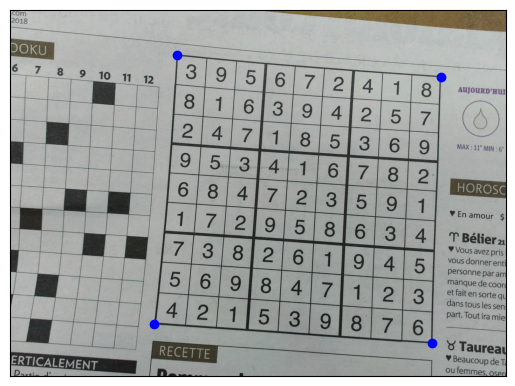

In [ ]:
perimeter = cv2.arcLength(curve=largest_countour, closed=True)

shape = cv2.approxPolyDP(curve=largest_countour, epsilon=0.01*perimeter, closed=True).reshape(4,2)
fig, ax = plt.subplots()
ax.imshow(sudoku_image)

for corner in shape:
  ax.scatter(corner[0], corner[1], color='blue')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

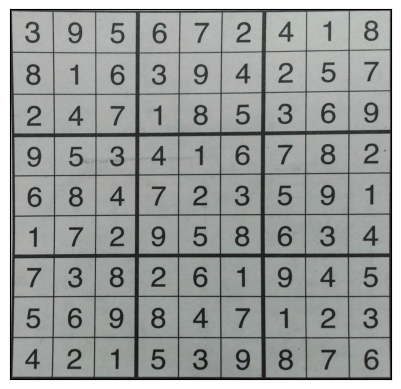

In [ ]:
original = sudoku_image.copy()

cropped = four_point_transform(original, shape)

fig, ax = plt.subplots()
ax.imshow(cropped)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Split image into individual cells

[]

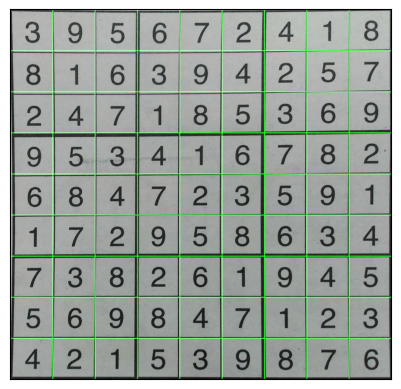

In [ ]:
extract_image = cropped.copy()

dx = extract_image.shape[0]//9
dy = extract_image.shape[1]//9

for i in range(1,9):
  extract_image[i*dx:i*dx+5, :, 1] = 255
  extract_image[:, i*dy:i*dy+5, 1] = 255

fig, ax = plt.subplots()

ax.imshow(extract_image)

ax.set_xticks([])
ax.set_yticks([])

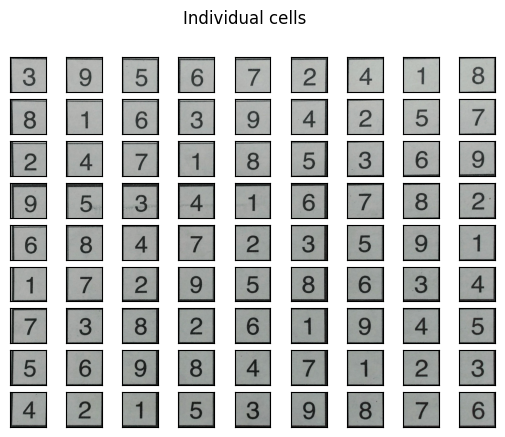

In [ ]:
fig, axs = plt.subplots(9,9)
fig.suptitle("Individual cells")

for x in range(9):
  for y in range(9):
    axs[x, y].imshow(cropped[dx*x:dx*(x+1), dy*y: dy*(y+1)])
    axs[x, y].set_xticks([])
    axs[x, y].set_yticks([])


plt.show()